TASK 1
About .7 perc acc w/ MLP based model 

In [1]:
# Probably more imports than are really necessary...
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random

In [2]:
def accuracy1(groundtruth, predictions):
    correct = 0
    for k in groundtruth:
        if not (k in predictions):
            print("Missing " + str(k) + " from predictions")
            return 0
        if predictions[k] == groundtruth[k]:
            correct += 1
    return correct / len(groundtruth)

In [3]:
dataroot1 = "data/student_files/task1_composer_classification/"

In [4]:
class model1():
    def __init__(self):
        pass

    def features(self, path):
        midi_obj = miditoolkit.midi.parser.MidiFile(dataroot1 + '/' + path)
        notes = midi_obj.instruments[0].notes
        num_notes = len(notes)
        average_pitch = sum([note.pitch for note in notes]) / num_notes
        average_duration = sum([note.end - note.start for note in notes]) / num_notes
        features = [average_pitch, average_duration]
        return features
    
    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
        for k in d:
            x = self.features(k)
            pred = self.model.predict([x])
            predictions[k] = str(pred[0])
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
        return predictions

    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    def train(self, path):
        with open(path, 'r') as f:
            train_json = eval(f.read())
        X_train = [self.features(k) for k in train_json]
        y_train = [train_json[k] for k in train_json]
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        self.model = model

In [5]:
def run1():
    model = model1()
    model.train(dataroot1 + "/train.json")
    train_preds = model.predict(dataroot1 + "/train.json")
    test_preds = model.predict(dataroot1 + "/test.json", "predictions1.json")
    
    train_labels = eval(open(dataroot1 + "/train.json").read())
    acc1 = accuracy1(train_labels, train_preds)
    print("Task 1 training accuracy = " + str(acc1))

Custom Model 

In [6]:
import ast

def create_artist_mapping(json_path):
    with open(json_path, 'r') as f:
        midi_to_artist = ast.literal_eval(f.read())
        

    unique_artists = sorted(set(midi_to_artist.values()))
    id_to_artist = {i: artist for i, artist in enumerate(unique_artists)}

    
    return id_to_artist
idToArtist = create_artist_mapping("data/student_files/task1_composer_classification/train.json")

In [7]:
print(len(idToArtist))
print(idToArtist)

artistToId={}
for key,value in idToArtist.items():
    artistToId[value] = key
print(artistToId)

8
{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Haydn', 4: 'Liszt', 5: 'Mozart', 6: 'Schubert', 7: 'Schumann'}
{'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Haydn': 3, 'Liszt': 4, 'Mozart': 5, 'Schubert': 6, 'Schumann': 7}


In [8]:
def save_model(model, filepath='sol_1.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_1.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model


In [9]:
from mido import MidiFile
from sklearn.model_selection import train_test_split
from itertools import islice
import fluidsynth

SAMPLE_RATE = 16000

# create train loader 


def get_lowest_pitch(file_path):
    # Initialize lowest_note to a high value (since MIDI notes are from 0 to 127)
    lowest_note = 128  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note < lowest_note:
                    lowest_note = msg.note
    
    # Return None if no note is found
    return lowest_note if lowest_note != 128 else None

def get_highest_pitch(file_path):
    # Initialize highest_note to a low value (since MIDI notes are from 0 to 127)
    highest_note = -1  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note > highest_note:
                    highest_note = msg.note
                    
    # Return None if no note is found
    return highest_note if highest_note != -1 else None

def get_unique_pitch_num(file_path):
    mid = MidiFile(file_path)
    notes = set()
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.add(msg.note)
    
    return len(notes)

def get_average_pitch_value(file_path):
    #Q8: Your code goes here
    mid = MidiFile(file_path)
    
    notes = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    
    if notes:
        return sum(notes) / len(notes)
    else:
        return None

def extract_waveform(path):
    # Your code here
    wave, sr = librosa.load(path, sr=SAMPLE_RATE)
    return wave 

def extract_q(w):
    # Your code here
    result = librosa.cqt(y=w, sr=SAMPLE_RATE)
    result = librosa.amplitude_to_db(np.abs(result))
    q =torch.FloatTensor(result)
    
    mean = q.mean(dim=1)  # shape: (84,)
    std = q.std(dim=1)    # shape: (84,)
    return torch.cat([mean, std], dim=0)  # shape: (168,)

def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 64)
    # extract mean and 
    means = np.mean(mfcc, axis=1)
    
    stds = np.std(mfcc, axis=1)
    # concatenate
    features = np.concatenate([means, stds])
    
    return torch.FloatTensor(features)

def extract_spec(w):
    # Your code here
    # load
    stft = librosa.stft(y=w)
    # take squared absolute values
    spec = np.abs(stft) ** 2
    
    spec = torch.FloatTensor(spec)
    
    mean = spec.mean(dim=1)  # shape (128,)
    std = spec.std(dim=1)    # shape (128,)
    return torch.cat([mean, std], dim=0)  # shape (256,)


import torch
import pretty_midi
from sklearn.model_selection import train_test_split

def features(path):
    full_path = dataroot1 + '/' + path
    try:
        midi_obj = pretty_midi.PrettyMIDI(full_path)
        w = midi_obj.fluidsynth(fs=SAMPLE_RATE)

        if w is None or len(w) < SAMPLE_RATE // 10:  # e.g. less than 0.1s
            raise ValueError("Waveform too short or empty")

        mfcc = extract_mfcc(w)
        spec = extract_spec(w)
        q = extract_q(w)

        extra = torch.tensor([
            get_lowest_pitch(full_path) or 0,
            get_highest_pitch(full_path) or 0,
            get_unique_pitch_num(full_path),
            get_average_pitch_value(full_path) or 0
        ], dtype=torch.float64)
        
        features = torch.cat(
            [
                mfcc, 
                spec, 
                q, 
                extra
            ]) 

        return features
    except Exception as e:
        print(f"Failed to process {full_path}: {e}")
        return None



from joblib import Parallel, delayed

def create_train_features(size=None, val_split=0.1, n_jobs=4):
    # Load data
    with open(dataroot1 + "/train.json", 'r') as f:
        train_json = eval(f.read())
    
    # Limit size if specified
    if size is not None:
        train_json = dict(list(train_json.items())[:size])
    
    # Parallel feature extraction
    keys = list(train_json.keys())
    values = list(train_json.values())

    X = Parallel(n_jobs=n_jobs)(
        delayed(features)(key) for key in keys
    )
    Y = [artistToId[value] for value in values]
    
    # Convert lists to tensors
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])
    Y = torch.tensor(Y, dtype=torch.int64)
    
    # Return all data if no validation split needed
    if val_split <= 0:
        return X, Y
    
    # Split into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=val_split, random_state=42, shuffle=True
    )
    
    return X_train, Y_train, X_val, Y_val


    
X_train, y_train, X_val, y_val = create_train_features()

print(X_train[0])
print(y_train[0])


tensor([-255.9119,  140.4222,  -41.8253,  ...,   89.0000,   39.0000,
          62.8079])
tensor(1)


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9272/2094906300.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])


In [10]:
# midi_obj = pretty_midi.PrettyMIDI("data/student_files/task1_composer_classification/midis/0.mid")
# w = midi_obj.fluidsynth()  # This converts MIDI to waveform
# print(w.shape)
# extract_q(w)

In [11]:
import pickle

# Replace with your actual file path
save_path = "task1_data.pkl"

data = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val
}

with open(save_path, "wb") as f:
    pickle.dump(data, f)

print(f"Saved dataset splits to: {save_path}")


Saved dataset splits to: task1_data.pkl


In [12]:
print(len(X_train[0]))
feature_size = (len(X_train[0]))


2350


In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

In [18]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=feature_size, num_classes=8):
        super().__init__()
        self.__init_args__ = (input_dim,)
        self.__init_kwargs__ = {'num_classes': num_classes}
        self.input_dim = input_dim
        
        # Feature processing network
        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            # nn.Linear(128, 128),
            # nn.BatchNorm1d(128),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.4)
        )
        
        # Attention mechanism for feature weighting
        self.attention = nn.Sequential(
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Process features
        features = self.feature_net(x)
        
        # Apply attention (optional branch)
        attention_weights = torch.sigmoid(self.attention(features))
        weighted_features = features * attention_weights
        
        # Final classification
        logits = self.classifier(weighted_features)
        return logits
        
    def extract_features(self, x):
        """Return intermediate feature representation"""
        return self.feature_net(x)

In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim


class model2():
    def __init__(self):
        self.model = MLPClassifier()
        self.train_acc = []
        self.val_acc = []
        return
    
    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
    
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.eval()
        self.model.to(device)
    
        for k in d:
            x = torch.tensor(features(k), dtype=torch.float32)
            x = x.unsqueeze(0).to(device)  # (1, feature_dim) or (1, C, H, W) depending on model
            with torch.no_grad():
                output = self.model(x)
                _, pred = torch.max(output, 1)
                predictions[k] = str(idToArtist[pred.item()])  # get scalar int from tensor
    
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
    
        return predictions


    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    import torch

    def train(self, train_loader, val_loader, epochs=5):
        torch.mps.empty_cache()

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        model = self.model
        model.to(device)

        criterion = nn.CrossEntropyLoss()  
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=5)
        
    
        train_acc = []
        val_acc = []
        
        # Early stopping params
        best_val_acc = 0.0
        patience_counter = 0
        patience= 10
    
        for epoch in range(epochs):
            model.train()
            correct_train = 0
            total_train = 0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += batch_y.size(0)
                correct_train += (predicted == batch_y).sum().item()
    
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
    
            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    outputs = model(batch_x)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += batch_y.size(0)
                    correct_val += (predicted == batch_y).sum().item()
    
            val_accuracy = correct_val / total_val
            val_acc.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
            # Step the LR scheduler
            scheduler.step(val_accuracy)
    
            # Early Stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_counter = 0
                best_model_state = model.state_dict()  # Save best model
                save_model(model, 'sol1_MLP_2.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
    
        # Load best model state
        model.load_state_dict(best_model_state)
    
        self.train_acc = train_acc
        self.val_acc = val_acc
        self.model = model
                
    def get_train_acc(self):
        return self.train_acc, self.val_acc
    
    def _get_model_copy(self, model):
        """Create a deep copy of the model."""
        model_copy = type(model)(*model.__init_args__, **model.__init_kwargs__)
        model_copy.load_state_dict(model.state_dict())
        return model_copy

In [32]:

EPOCHS = 300
model = model2()
model.train(train_loader, val_loader, EPOCHS)


# train_preds = model.predict(dataroot1 + "/train.json")
# test_preds = model.predict(dataroot1 + "/test.json", "predictions1.json")
# 
# train_labels = eval(open(dataroot1 + "/train.json").read())
# acc1 = accuracy1(train_labels, train_preds)
# print("Task 1 training accuracy = " + str(acc1))

Epoch [1/300], Train Accuracy: 0.4182, Validation Accuracy: 0.5104
Model saved to sol1_MLP_2.pt
Epoch [2/300], Train Accuracy: 0.5368, Validation Accuracy: 0.5833
Model saved to sol1_MLP_2.pt
Epoch [3/300], Train Accuracy: 0.5754, Validation Accuracy: 0.6042
Model saved to sol1_MLP_2.pt
Epoch [4/300], Train Accuracy: 0.5708, Validation Accuracy: 0.5312
Epoch [5/300], Train Accuracy: 0.6029, Validation Accuracy: 0.6250
Model saved to sol1_MLP_2.pt
Epoch [6/300], Train Accuracy: 0.6186, Validation Accuracy: 0.5729
Epoch [7/300], Train Accuracy: 0.6278, Validation Accuracy: 0.5729
Epoch [8/300], Train Accuracy: 0.6305, Validation Accuracy: 0.6042
Epoch [9/300], Train Accuracy: 0.6443, Validation Accuracy: 0.6146
Epoch [10/300], Train Accuracy: 0.6167, Validation Accuracy: 0.5625
Epoch [11/300], Train Accuracy: 0.6599, Validation Accuracy: 0.6042
Epoch [12/300], Train Accuracy: 0.6452, Validation Accuracy: 0.5312
Epoch [13/300], Train Accuracy: 0.6544, Validation Accuracy: 0.6979
Model sav

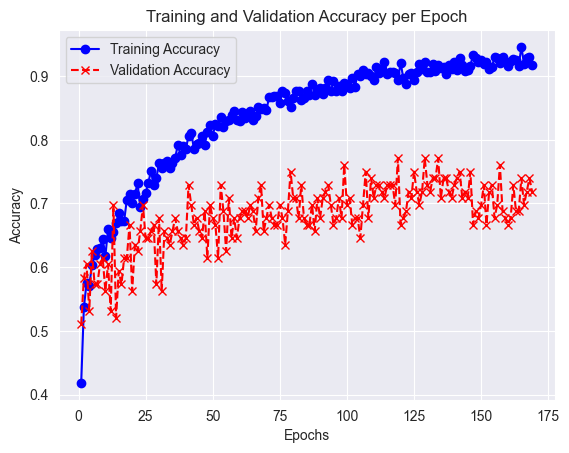

In [33]:
import matplotlib.pyplot as plt

train_acc, val_acc = model.get_train_acc()



x = range(1, len(train_acc) + 1)

# Plot training accuracy
plt.plot(x, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')

# Plot validation accuracy
plt.plot(x, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [34]:
import pickle
with open('fullTrainData.pkl', 'wb') as f:
    data = {'train_loader': train_loader, 'val_loader':val_loader, 'train_dataset': train_dataset, 'val_dataset':val_dataset}
    pickle.dump(data, f)

Make predictions

In [35]:
# model = model2()
# MLP = MLPClassifier()
# MLP = load_model(MLPClassifier, "sol1_MLP.pt")

In [36]:
# model.model = MLP

In [37]:
model.predict(dataroot1+"/test.json", outpath="predictions1.json")

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9272/3284981968.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features(k), dtype=torch.float32)


{'midis/1210.mid': 'Bach',
 'midis/1211.mid': 'Beethoven',
 'midis/1212.mid': 'Beethoven',
 'midis/1213.mid': 'Chopin',
 'midis/1214.mid': 'Beethoven',
 'midis/1215.mid': 'Bach',
 'midis/1216.mid': 'Schumann',
 'midis/1217.mid': 'Haydn',
 'midis/1218.mid': 'Bach',
 'midis/1219.mid': 'Beethoven',
 'midis/1220.mid': 'Haydn',
 'midis/1221.mid': 'Chopin',
 'midis/1222.mid': 'Beethoven',
 'midis/1223.mid': 'Beethoven',
 'midis/1224.mid': 'Beethoven',
 'midis/1225.mid': 'Bach',
 'midis/1226.mid': 'Beethoven',
 'midis/1227.mid': 'Chopin',
 'midis/1228.mid': 'Schumann',
 'midis/1229.mid': 'Beethoven',
 'midis/1230.mid': 'Liszt',
 'midis/1231.mid': 'Beethoven',
 'midis/1232.mid': 'Chopin',
 'midis/1233.mid': 'Liszt',
 'midis/1234.mid': 'Schubert',
 'midis/1235.mid': 'Schubert',
 'midis/1236.mid': 'Liszt',
 'midis/1237.mid': 'Schubert',
 'midis/1238.mid': 'Schubert',
 'midis/1239.mid': 'Beethoven',
 'midis/1240.mid': 'Beethoven',
 'midis/1241.mid': 'Beethoven',
 'midis/1242.mid': 'Beethoven',
 '

In [58]:
from pytorch_tabnet.tab_model import TabNetClassifier


from pytorch_tabnet.tab_model import TabNetClassifier

tab = TabNetClassifier(
    n_d=1024,                    # Width of decision prediction layer
    n_a=128,                    # Width of attention embedding
    # n_steps=5,                 # Number of decision steps
    # gamma=1.5,                 # Relaxation parameter in sparsemax
    # lambda_sparse=1e-4,        # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.001),
    scheduler_params={"step_size": 10, "gamma": 0.9},  # Learning rate scheduler
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',        # Try 'entmax' (or fallback to 'sparsemax')
    verbose=1
)

tab.fit(
    X_train=X_train.numpy(), 
    y_train=y_train.numpy(),
    eval_set=[(X_val.numpy(), y_val.numpy())],
    eval_name=["val"],
    eval_metric=["accuracy"],   # Try: "accuracy", "logloss", "auc", "balanced_accuracy"
    max_epochs=200,
    patience=20,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.1018  | val_accuracy: 0.08264 |  0:00:02s
epoch 1  | loss: 5.53447 | val_accuracy: 0.1405  |  0:00:03s
epoch 2  | loss: 4.7496  | val_accuracy: 0.28926 |  0:00:04s
epoch 3  | loss: 3.77169 | val_accuracy: 0.39669 |  0:00:05s
epoch 4  | loss: 3.30748 | val_accuracy: 0.39669 |  0:00:07s
epoch 5  | loss: 3.26651 | val_accuracy: 0.36364 |  0:00:08s
epoch 6  | loss: 3.09013 | val_accuracy: 0.33884 |  0:00:09s
epoch 7  | loss: 3.08457 | val_accuracy: 0.33058 |  0:00:10s
epoch 8  | loss: 2.99407 | val_accuracy: 0.33058 |  0:00:11s
epoch 9  | loss: 2.90112 | val_accuracy: 0.31405 |  0:00:12s
epoch 10 | loss: 2.72629 | val_accuracy: 0.32231 |  0:00:14s
epoch 11 | loss: 2.6929  | val_accuracy: 0.30579 |  0:00:15s
epoch 12 | loss: 2.64355 | val_accuracy: 0.32231 |  0:00:16s
epoch 13 | loss: 2.66028 | val_accuracy: 0.33884 |  0:00:17s
epoch 14 | loss: 2.62915 | val_accuracy: 0.3719  |  0:00:18s
epoch 15 | loss: 2.47657 | val_accuracy: 0.36364 |  0:00:19s
epoch 16 | loss: 2.51599

/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [50]:
import numpy as np

def predict(path, outpath=None):
    # Load your input dictionary
    d = eval(open(path, 'r').read())
    predictions = {}

    # Prepare batch inputs
    keys = list(d)
    X = np.array([features(k) for k in keys], dtype=np.float32)  # shape: (N, feature_dim)

    # Predict using TabNet
    preds = tab.predict(X)  # shape: (N,)
    
    # Map predictions back to composer names
    for key, pred in zip(keys, preds):
        predictions[key] = str(idToArtist[int(pred)])

    # Optionally save results
    if outpath:
        with open(outpath, "w") as z:
            z.write(str(predictions) + '\n')

    return predictions


In [51]:
predict(dataroot1+"/test.json", "predictions1.json")

{'midis/1210.mid': 'Schumann',
 'midis/1211.mid': 'Beethoven',
 'midis/1212.mid': 'Beethoven',
 'midis/1213.mid': 'Beethoven',
 'midis/1214.mid': 'Beethoven',
 'midis/1215.mid': 'Schumann',
 'midis/1216.mid': 'Beethoven',
 'midis/1217.mid': 'Beethoven',
 'midis/1218.mid': 'Beethoven',
 'midis/1219.mid': 'Beethoven',
 'midis/1220.mid': 'Beethoven',
 'midis/1221.mid': 'Beethoven',
 'midis/1222.mid': 'Chopin',
 'midis/1223.mid': 'Beethoven',
 'midis/1224.mid': 'Beethoven',
 'midis/1225.mid': 'Beethoven',
 'midis/1226.mid': 'Beethoven',
 'midis/1227.mid': 'Beethoven',
 'midis/1228.mid': 'Beethoven',
 'midis/1229.mid': 'Beethoven',
 'midis/1230.mid': 'Beethoven',
 'midis/1231.mid': 'Beethoven',
 'midis/1232.mid': 'Beethoven',
 'midis/1233.mid': 'Beethoven',
 'midis/1234.mid': 'Beethoven',
 'midis/1235.mid': 'Chopin',
 'midis/1236.mid': 'Beethoven',
 'midis/1237.mid': 'Beethoven',
 'midis/1238.mid': 'Beethoven',
 'midis/1239.mid': 'Beethoven',
 'midis/1240.mid': 'Beethoven',
 'midis/1241.mid

Task: next sequence prediction. 
Would the next midi file follow this one? 

baseline acc is about .6

In [7]:
# Probably more imports than are really necessary...
import os
import pickle

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi


In [2]:
def accuracy2(groundtruth, predictions):
    correct = 0
    for k in groundtruth:
        if not (k in predictions):
            print("Missing " + str(k) + " from predictions")
            return 0
        if predictions[k] == groundtruth[k]:
            correct += 1
    return correct / len(groundtruth)

In [2]:
dataroot2 = "data/student_files/task2_next_sequence_prediction/"

In [4]:
class model2():
    def __init__(self):
        pass

    def features(self, path):
        midi_obj = miditoolkit.midi.parser.MidiFile(dataroot2 + '/' + path)
        notes = midi_obj.instruments[0].notes
        num_notes = len(notes)
        average_pitch = sum([note.pitch for note in notes]) / num_notes
        features = [average_pitch]
        return features
    
    def train(self, path):
        # This baseline doesn't use any model (it just measures feature similarity)
        # You can use this approach but *probably* you'll want to implement a model
        pass

    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
        for k in d:
            path1,path2 = k # Keys are pairs of paths
            x1 = self.features(path1)
            x2 = self.features(path2)
            # Note: hardcoded difference between features
            if abs(x1[0] - x2[0]) < 5:
                predictions[k] = True
            else:
                predictions[k] = False
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
        return predictions

In [5]:
def run2():
    model = model2()
    model.train(dataroot2 + "/train.json")
    train_preds = model.predict(dataroot2 + "/train.json")
    test_preds = model.predict(dataroot2 + "/test.json", "predictions2.json")
    
    train_labels = eval(open(dataroot2 + "/train.json").read())
    acc2 = accuracy2(train_labels, train_preds)
    print("Task 2 training accuracy = " + str(acc2))

In [6]:
# run2()

CUSTOM MODEL

note: even basic feature similarity seems to be doing pretty good

First, load in data. 
Create a small dataset for overfitting, and an actual large one

data is coming in as {(file1,file2):T/F,....}
convert to X = [similarity scores, raw features1, raw features2] and y=t/f

In [8]:
from mido import MidiFile

SAMPLE_RATE = 25000

# create train loader 


def get_lowest_pitch(file_path):
    # Initialize lowest_note to a high value (since MIDI notes are from 0 to 127)
    lowest_note = 128  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note < lowest_note:
                    lowest_note = msg.note
    
    # Return None if no note is found
    return lowest_note if lowest_note != 128 else None

def get_highest_pitch(file_path):
    # Initialize highest_note to a low value (since MIDI notes are from 0 to 127)
    highest_note = -1  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note > highest_note:
                    highest_note = msg.note
                    
    # Return None if no note is found
    return highest_note if highest_note != -1 else None

def get_unique_pitch_num(file_path):
    mid = MidiFile(file_path)
    notes = set()
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.add(msg.note)
    
    return len(notes)

def get_average_pitch_value(file_path):
    #Q8: Your code goes here
    mid = MidiFile(file_path)
    
    notes = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    
    if notes:
        return sum(notes) / len(notes)
    else:
        return None

def extract_waveform(path):
    # Your code here
    wave, sr = librosa.load(path, sr=SAMPLE_RATE)
    return wave 

def extract_q(w):
    # Your code here
    result = librosa.cqt(y=w, sr=SAMPLE_RATE)
    result = librosa.amplitude_to_db(np.abs(result))
    
    return torch.FloatTensor(result)

def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 13)
    # extract mean and 
    means = np.mean(mfcc, axis=1)
    
    stds = np.std(mfcc, axis=1)
    # concatenate
    features = np.concatenate([means, stds])
    
    return torch.FloatTensor(features)

def extract_spec(w):
    # Your code here
    # load
    stft = librosa.stft(y=w)
    # take squared absolute values
    spec = np.abs(stft) ** 2
    
    return torch.FloatTensor(spec)


def pad_or_truncate(spec, max_time=500):
    freq_bins, time_bins = spec.shape
    if time_bins > max_time:
        return spec[:, :max_time]
    elif time_bins < max_time:
        pad_width = max_time - time_bins
        return F.pad(spec, (0, pad_width), mode='constant', value=0)
    return spec

from mido import MidiFile

def pitch_class_profile(path):
    # Initialize an array to count occurrences of each pitch class (12 semitones)
    pitch_class_counts = [0] * 12
    
    # Load the MIDI file
    mid = MidiFile(path)
    
    # Iterate through each track in the MIDI file
    for track in mid.tracks:
        # Track MIDI events
        time = 0
        for msg in track:
            time += msg.time  # accumulate time (not used directly here, but part of the MIDI structure)
            
            # Process note-on and note-off events
            if msg.type in ['note_on', 'note_off']:
                # We care about note_on events to track pitches
                if msg.type == 'note_on' and msg.velocity > 0:  # Only count note_on with non-zero velocity
                    pitch = msg.note  # MIDI note number (e.g., 60 is Middle C)
                    # Convert to pitch class (0-11)
                    pitch_class = pitch % 12
                    pitch_class_counts[pitch_class] += 1
    
    # Normalize the pitch class counts to get a distribution
    total_notes = sum(pitch_class_counts)
    if total_notes > 0:
        pitch_class_profile = [count / total_notes for count in pitch_class_counts]
    else:
        pitch_class_profile = [0] * 12  # If no notes are found, return an all-zero vector
    
    
    return torch.tensor(pitch_class_profile)


def get_key_signature(path):
    # Load the MIDI file
    midi = MidiFile(path)
    
    # Iterate through all tracks in the MIDI file
    for track in midi.tracks:
        for msg in track:
            # Look for meta events of type 'key_signature'
            if msg.type == 'key_signature':
                # Extract the key and mode from the key_signature meta message
                key = msg.key
                
                return key  # Return key and mode
    
    # Return None if no key_signature meta message was found
    print('no key found')
    return None


In [9]:
def features(path):
    full_path = dataroot2 + '/' + path
    try:
        midi_obj = pretty_midi.PrettyMIDI(full_path)
        w = midi_obj.fluidsynth()

        mfcc = extract_mfcc(w)
        spec = extract_spec(w).mean(dim=1)
        q = extract_q(w).mean(dim=1)
        pitch_distribution = pitch_class_profile(full_path)
        key_signature = get_key_signature(full_path)

        
        # want things like... 
        # key signature
        # pitch interval analysis -> average size of intervals between notes
        
        
        extra = torch.tensor([
            get_lowest_pitch(full_path) or 0,
            get_highest_pitch(full_path) or 0,
            get_unique_pitch_num(full_path),
            get_average_pitch_value(full_path) or 0
        ], dtype=torch.float64)

        # return torch.cat([mfcc, spec, q, extra])
        return mfcc, spec, q, pitch_distribution, key_signature, extra
    except Exception as e:
        print(f"Failed to process {full_path}: {e}")
        return None

In [10]:
def test_features():
    path = 'midis/0.mid'
    feats = features(path)
    
    if feats is None:
        print("Feature extraction failed.")
        return

    mfcc, spec, q, pitch_dist, key_sig, extra = feats

    print("MFCC shape:", mfcc.shape)
    print("Spectrogram shape:", spec.shape)
    print("Q-Transform shape:", q.shape)
    print("Pitch distribution shape:", pitch_dist.shape)
    print("Key signature:", key_sig)
    print("Extra shape:", extra.shape)

    # Basic sanity checks (can be modified to assert instead of print if desired)
    assert isinstance(mfcc, torch.Tensor)
    assert isinstance(spec, torch.Tensor)
    assert isinstance(q, torch.Tensor)
    assert isinstance(pitch_dist, torch.Tensor)
    assert isinstance(extra, torch.Tensor)
    assert extra.shape[0] == 4

    print("All feature checks passed.")

In [11]:
test_features()

MFCC shape: torch.Size([26])
Spectrogram shape: torch.Size([1025])
Q-Transform shape: torch.Size([84])
Pitch distribution shape: torch.Size([12])
Key signature: F#
Extra shape: torch.Size([4])
All feature checks passed.


In [12]:
import scipy
from scipy.spatial.distance import euclidean
import ast
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance
from fastdtw import fastdtw
from joblib import Parallel, delayed
from functools import partial
import tqdm.notebook as tqdm



X_data_small, Y_data_small = [],[]
X_data, Y_data = [], []


def process_pair_predict(tuple):
    """Process a single pair of files and compute similarity metrics"""
    file1, file2 = str(tuple[0]), str(tuple[1])
    
    # Extract features for each file
    mfcc1, spec1, q1, pitch1, key1, extra1 = features(file1)
    mfcc2, spec2, q2, pitch2, key2, extra2 = features(file2)
    
    # Calculate similarity metrics
    sim_mfcc = euclidean(mfcc1, mfcc2)
    sim_spec = cosine_similarity(mfcc1.reshape(1, -1), mfcc2.reshape(1, -1))[0][0]
    sim_pitch = wasserstein_distance(pitch1, pitch2)
    sim_key = 1 if str(key1) == str(key2) else 0
    sim_extra = cosine_similarity(extra1.reshape(1, -1), extra2.reshape(1, -1))[0][0]
    
    # Create feature vector
    features_vector = [sim_mfcc, sim_spec, sim_pitch, sim_key, sim_extra]
    
    # Add statistical features
    features_vector.extend([mfcc1.mean(), mfcc2.mean(), mfcc1.std(), mfcc2.std(),
                           spec1.mean(), spec2.mean(), spec1.std(), spec2.std()])
    
    # Add extra features
    features_vector.extend(extra1.tolist())
    features_vector.extend(extra2.tolist())
    
    return features_vector

def process_pair(key_value_pair, features_func):
    """Process a single pair of files and compute similarity metrics"""
    key, value = key_value_pair
    file1, file2 = str(key[0]), str(key[1])
    y = value
    
    # Extract features for each file
    mfcc1, spec1, q1, pitch1, key1, extra1 = features_func(file1)
    mfcc2, spec2, q2, pitch2, key2, extra2 = features_func(file2)
    
    # Calculate similarity metrics
    sim_mfcc = euclidean(mfcc1, mfcc2)
    sim_spec = cosine_similarity(mfcc1.reshape(1, -1), mfcc2.reshape(1, -1))[0][0]
    sim_pitch = wasserstein_distance(pitch1, pitch2)
    sim_key = 1 if str(key1) == str(key2) else 0
    sim_extra = cosine_similarity(extra1.reshape(1, -1), extra2.reshape(1, -1))[0][0]
    
    # Create feature vector
    features_vector = [sim_mfcc, sim_spec, sim_pitch, sim_key, sim_extra]
    
    # Add statistical features
    features_vector.extend([mfcc1.mean(), mfcc2.mean(), mfcc1.std(), mfcc2.std(),
                           spec1.mean(), spec2.mean(), spec1.std(), spec2.std()])
    
    # Add extra features
    features_vector.extend(extra1.tolist())
    features_vector.extend(extra2.tolist())
    
    return features_vector, y

def create_datasets(size=None, n_jobs=4):
    """
    Create datasets with parallelized processing
    
    Args:
        size: Optional limit on number of samples to process
        n_jobs: Number of parallel jobs to run
        
    Returns:
        X_data, Y_data: Features and labels
    """
    # Load data
    with open(dataroot2 + "/train.json", 'r') as f:
        data = ast.literal_eval(f.read())
    
    # Shuffle and crop data if size limit
    if size:
        items = list(data.items())
        random.shuffle(items)
        items = items[:size]
        data = dict(items)
    
    # Create list of key-value pairs for parallel processing
    items = list(data.items())
    
    # Create a partial function with the features function
    process_func = partial(process_pair, features_func=features)
    
    # Process pairs in parallel
    # Process pairs in parallel with progress bar
    print(f"Processing {len(items)} file pairs using {n_jobs} parallel jobs...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_func)(item) for item in tqdm.tqdm(items, desc="Processing file pairs")
    )
    
    # Count and filter failed results
    num_failed = sum(r is None for r in results)
    results = [r for r in results if r is not None]
    
    print(f"{num_failed} items failed to process and were skipped.")
    
    # Split results into X and Y
    X_data, Y_data = zip(*results) if results else ([], [])
    
    # Print class distribution
    positive_count = sum(Y_data)
    negative_count = len(Y_data) - positive_count
    print(f"Positive examples: {positive_count}, Negative examples: {negative_count}")
    
    return list(X_data), list(Y_data)

In [13]:
# load data
with open("task2_train_data.pkl", "rb") as file:
    data = pickle.load(file)

X_data = data['x']
y_data = data['y']

In [13]:
# X_data, y_data = create_datasets()  # uncomment to re-run features on training data
feature_size = len(X_data[0])
print(f"Feature size: {feature_size}")
print(f"Data size: {len(X_data)}")

Processing 9558 file pairs using 4 parallel jobs...


Processing file pairs:   0%|          | 0/9558 [00:00<?, ?it/s]

0 items failed to process and were skipped.
Positive examples: 4779, Negative examples: 4779
Feature size: 21
Data size: 9558


In [33]:
# Save data
import pickle

train_data_dict = {'x': X_data, 'y': y_data}

with open("task2_train_data.pkl", "wb") as file:
    pickle.dump(train_data_dict, file)

# check if pickle file exists. if not, run create_datasets and save to pickle

In [21]:
feature_size = len(X_data[0])
feature_size

21

In [15]:
# Zip and shuffle together to maintain correspondence
combined = list(zip(X_data, y_data))
random.shuffle(combined)

# Split index for 80/20
split_idx = int(0.8 * len(combined))

# Unzip into train and val sets
train_data = combined[:split_idx]
val_data = combined[split_idx:]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

# Optionally convert back to lists
X_train, y_train = list(X_train), list(y_train)
X_val, y_val = list(X_val), list(y_val)
    
# check that the distribution is still 50-50 between true and false 
print('validation distribution split:', sum(y_val) / len(y_val))
print('training distribution split:', sum(y_train) / len(y_train))

validation distribution split: 0.49215481171548114
training distribution split: 0.5019618100967826


In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int)  # or float if doing regression

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Model Business
Create model architecture

In [22]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=feature_size, num_classes=2):
        super().__init__()
        self.__init_args__ = (input_dim,)
        self.__init_kwargs__ = {'num_classes': num_classes}
        self.input_dim = input_dim
        
        # Feature processing network
        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            # nn.Linear(128, 128),
            # nn.BatchNorm1d(128),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.4)
        )
        
        # Attention mechanism for feature weighting
        # self.attention = nn.Sequential(
        #     nn.Linear(128, 256),
        #     nn.Tanh(),
        #     nn.Linear(256, 1)
        # )
        
        # Classification head
        self.classifier = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Process features
        features = self.feature_net(x)
        
        # Apply attention (optional branch)
        # attention_weights = torch.sigmoid(self.attention(features))
        # weighted_features = features * attention_weights
        
        # Final classification
        logits = self.classifier(features)
        return logits
        
    def extract_features(self, x):
        """Return intermediate feature representation"""
        return self.feature_net(x)

In [23]:
def save_model(model, filepath='sol_2.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_2.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model


Process Test Data

In [49]:
# helper function to process test inputs
def process_test_data(path, n_jobs=4):
    print("Loading test data...")
    with open(path, 'r') as f:
        data = ast.literal_eval(f.read())
    
    print(f"Total test samples: {len(data)}")

    # Parallelize feature processing
    print(f"Extracting features in parallel using {n_jobs} workers...")
    process_func = partial(process_pair_predict)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_func)(data) for data in tqdm.tqdm(data, desc="Processing test pairs")
    )
    
    # Filter out failed results
    results = [r for r in results if r is not None]
    if len(results) < len(data):
        print(f"Warning: {len(data) - len(results)} samples failed during feature extraction.")
    
    return results

In [50]:
# processed_test_data = process_test_data(dataroot2 + "/test.json")

Loading test data...
Total test samples: 3070
Extracting features in parallel using 4 workers...



Processing test pairs: 100%|██████████| 3070/3070 [03:12<00:00, 15.97it/s]


In [51]:
# # save processed data to pickle file
# with open("task2_test_data.pkl", "wb") as file:
#     pickle.dump(processed_test_data, file)

In [24]:
# load processed data
with open("task2_test_data.pkl", "rb") as file:
    processed_test_data = pickle.load(file)

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from joblib import Parallel, delayed
from functools import partial
import tqdm
import torch

class model1():
    def __init__(self):
        self.model = MLPClassifier()
        self.train_acc = []
        self.val_acc = []
        return
    
    def predict_instance(self, file1, file2):
        model = self.model
        device = torch.device("cpu")
        model.to(device)
        model.eval()
        
        x = process_pair_predict((file1, file2))  # Already returns features
        x = torch.tensor(x, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        output = model(x)
        predicted = torch.argmax(output, dim=1).bool().tolist()
        return predicted


    def predict(self, path, outpath=None, n_jobs=4, processed_data=None):
        import ast
        device = torch.device("cpu")
        model = self.model
        model.to(device)
        model.eval()
    
        if not processed_data:
            print("Test data not pre-processed")
    
            print("Loading test data...")
            with open(path, 'r') as f:
                data = ast.literal_eval(f.read())
    
            print(f"Total test samples: {len(data)}")
    
            # Parallelize feature processing
            print(f"Extracting features in parallel using {n_jobs} workers...")
            process_func = partial(process_pair_predict)
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_func)(d) for d in tqdm.tqdm(data, desc="Processing test pairs")
            )
    
            # Filter out failed results
            results = [r for r in results if r is not None]
            if len(results) < len(data):
                print(f"Warning: {len(data) - len(results)} samples failed during feature extraction.")
        else:
            results = processed_data
    
            # You still need to load raw data to get the keys
            with open(path, 'r') as f:
                data = ast.literal_eval(f.read())
    
        # Convert to tensor
        xTest = torch.tensor(results, dtype=torch.float32).to(device)
    
        # Make predictions
        print("Running predictions...")
        with torch.no_grad():
            outputs = model(xTest)
            predicted = torch.argmax(outputs, dim=1)
            predicted_bool = predicted.bool().tolist()
    
        # Map predictions to keys
        predictions = dict(zip(data, predicted_bool))
    
        # Optionally write output
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
            print(f"Predictions written to {outpath}")
    
        print("Prediction process completed.")
        return predictions




    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    import torch

    def train(self, train_loader, val_loader, epochs=100):
        torch.mps.empty_cache()

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        model = self.model
        model.to(device)

        criterion = nn.CrossEntropyLoss()  
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
        
    
        train_acc = []
        val_acc = []
    
        best_val_acc = 0.0
        patience_counter = 0
        patience=10
    
        for epoch in range(epochs):
            model.train()
            correct_train = 0
            total_train = 0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += batch_y.size(0)
                correct_train += (predicted == batch_y).sum().item()
    
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
    
            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    outputs = model(batch_x)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += batch_y.size(0)
                    correct_val += (predicted == batch_y).sum().item()
    
            val_accuracy = correct_val / total_val
            val_acc.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
            # Step the LR scheduler
            scheduler.step(val_accuracy)
    
            # Early Stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_counter = 0
                best_model_state = model.state_dict()  # Save best model
                save_model(model, 'sol2_MLP_1.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
    
        # Load best model state
        model.load_state_dict(best_model_state)
    
        self.train_acc = train_acc
        self.val_acc = val_acc
        self.model = model
                
    def get_train_acc(self):
        return self.train_acc, self.val_acc
    
    def _get_model_copy(self, model):
        """Create a deep copy of the model."""
        model_copy = type(model)(*model.__init_args__, **model.__init_kwargs__)
        model_copy.load_state_dict(model.state_dict())
        return model_copy

In [26]:
EPOCHS = 100
model = model1()
model.train(train_loader, val_loader, EPOCHS)

Epoch [1/100], Train Accuracy: 0.6386, Validation Accuracy: 0.7008
Model saved to sol2_MLP_1.pt
Epoch [2/100], Train Accuracy: 0.6822, Validation Accuracy: 0.7186
Model saved to sol2_MLP_1.pt
Epoch [3/100], Train Accuracy: 0.6917, Validation Accuracy: 0.7296
Model saved to sol2_MLP_1.pt
Epoch [4/100], Train Accuracy: 0.7406, Validation Accuracy: 0.8499
Model saved to sol2_MLP_1.pt
Epoch [5/100], Train Accuracy: 0.8208, Validation Accuracy: 0.8985
Model saved to sol2_MLP_1.pt
Epoch [6/100], Train Accuracy: 0.8657, Validation Accuracy: 0.9100
Model saved to sol2_MLP_1.pt
Epoch [7/100], Train Accuracy: 0.8909, Validation Accuracy: 0.9257
Model saved to sol2_MLP_1.pt
Epoch [8/100], Train Accuracy: 0.9010, Validation Accuracy: 0.9236
Epoch [9/100], Train Accuracy: 0.9122, Validation Accuracy: 0.9236
Epoch [10/100], Train Accuracy: 0.9135, Validation Accuracy: 0.9247
Epoch [11/100], Train Accuracy: 0.9139, Validation Accuracy: 0.9247
Epoch [12/100], Train Accuracy: 0.9147, Validation Accurac

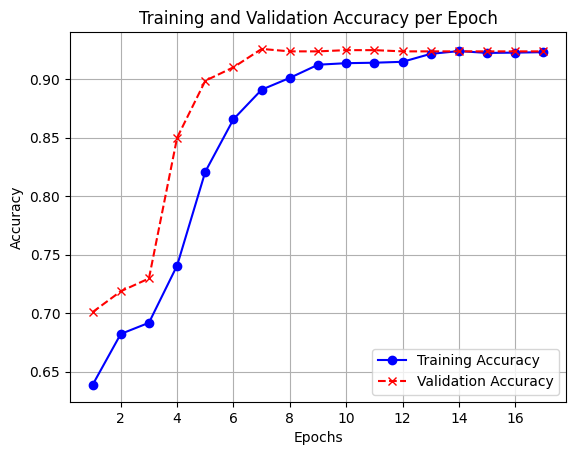

In [27]:
import matplotlib.pyplot as plt

train_acc, val_acc = model.get_train_acc()



x = range(1, len(train_acc) + 1)

# Plot training accuracy
plt.plot(x, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')

# Plot validation accuracy
plt.plot(x, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Predictions on Test Data

In [28]:
# do predictions on the test data 

In [32]:
model.predict_instance('midis/882.mid', 'midis/4220.mid')

[True]

In [30]:
test_preds = model.predict(dataroot2 + "/test.json", "predictions2.json", processed_data=processed_test_data)

Running predictions...
Predictions written to predictions2.json
Prediction process completed.


In [7]:
# Probably more imports than are really necessary...
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import librosa


In [2]:
TAGS = ['rock', 'oldies', 'jazz', 'pop', 'dance', 'blues', 'punk', 'chill', 'electronic', 'country']
tag_to_index = {tag: i for i, tag in enumerate(TAGS)}


# do multi-hot encoding

def multi_hot_encode(tags):
    """
    Given a list of tag strings, return a multi-hot encoded tensor.
    Example input: ['jazz', 'pop']
    Output: tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
    """
    vec = torch.zeros(len(TAGS), dtype=torch.float32)
    for tag in tags:
        if tag in tag_to_index:
            vec[tag_to_index[tag]] = 1.0
        else:
            raise ValueError(f"Unknown tag: {tag}")
    return vec


In [3]:
dataroot3 = "data/student_files/task3_audio_classification/"

In [4]:
def save_model(model, filepath='sol_1.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_1.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model

In [35]:
from mido import MidiFile
from sklearn.model_selection import train_test_split
from itertools import islice
import librosa

SAMPLE_RATE = 16000

# create train loader 


def get_lowest_pitch(file_path):
    # Initialize lowest_note to a high value (since MIDI notes are from 0 to 127)
    lowest_note = 128  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note < lowest_note:
                    lowest_note = msg.note
    
    # Return None if no note is found
    return lowest_note if lowest_note != 128 else None

def get_highest_pitch(file_path):
    # Initialize highest_note to a low value (since MIDI notes are from 0 to 127)
    highest_note = -1  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note > highest_note:
                    highest_note = msg.note
                    
    # Return None if no note is found
    return highest_note if highest_note != -1 else None

def get_unique_pitch_num(file_path):
    mid = MidiFile(file_path)
    notes = set()
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.add(msg.note)
    
    return len(notes)

def get_average_pitch_value(file_path):
    #Q8: Your code goes here
    mid = MidiFile(file_path)
    
    notes = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    
    if notes:
        return sum(notes) / len(notes)
    else:
        return None

def extract_waveform(path):
    waveform, sr = librosa.load(path, sr=SAMPLE_RATE)  # waveform: 1D NumPy array
    waveform = torch.FloatTensor(waveform)              # Convert to 1D torch tensor

    if sr != SAMPLE_RATE:
        resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
        waveform = resample(waveform.unsqueeze(0)).squeeze(0)  # (1, N) → (N,)

    # Pad or trim to target length (10 seconds)
    target_len = SAMPLE_RATE * 10
    if waveform.shape[0] < target_len:
        pad_len = target_len - waveform.shape[0]
        waveform = F.pad(waveform, (0, pad_len))
    else:
        waveform = waveform[:target_len]

    return waveform.numpy()  # shape: (160000,)


def extract_q(w):
    # Your code here
    result = librosa.cqt(y=w, sr=SAMPLE_RATE)
    result = librosa.amplitude_to_db(np.abs(result))
    q =torch.FloatTensor(result)
    
    mean = q.mean(dim=1)  # shape: (84,)
    std = q.std(dim=1)    # shape: (84,)
    return torch.cat([mean, std], dim=0)  # shape: (168,)

def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 13)
    # extract mean and 
    means = np.mean(mfcc, axis=1)
    
    stds = np.std(mfcc, axis=1)
    # concatenate
    features = np.concatenate([means, stds])
    
    return torch.FloatTensor(features)

def extract_spec(w):
    # Your code here
    # load
    stft = librosa.stft(y=w)
    # take squared absolute values
    spec = np.abs(stft) ** 2
    
    spec = torch.FloatTensor(spec)
    
    mean = spec.mean(dim=1)  # shape (128,)
    std = spec.std(dim=1)    # shape (128,)
    return torch.cat([mean, std], dim=0)  # shape (256,)


import torch
import pretty_midi
from sklearn.model_selection import train_test_split

def features(path):
    full_path = dataroot3 + '/' + path
    try:
        w = extract_waveform(full_path)
        # midi_obj = pretty_midi.PrettyMIDI(full_path)
        # w = midi_obj.fluidsynth(fs=SAMPLE_RATE)

        if w is None or len(w) < SAMPLE_RATE // 10:  # e.g. less than 0.1s
            raise ValueError("Waveform too short or empty")

        mfcc = extract_mfcc(w)
        spec = extract_spec(w)
        q = extract_q(w)
        
        features = torch.cat(
            [
                mfcc, 
                spec, 
                q
            ]) 

        return features
    except Exception as e:
        print(f"Failed to process {full_path}: {e}")
        return None

from joblib import Parallel, delayed

def create_train_features(size=None, val_split=0.2, n_jobs=4):
    # Load data
    with open(dataroot3 + "/train.json", 'r') as f:
        train_json = eval(f.read())
    
    # Limit size if specified
    if size is not None:
        train_json = dict(list(train_json.items())[:size])
    
    # Parallel feature extraction
    keys = list(train_json.keys())
    values = list(train_json.values())

    X = Parallel(n_jobs=n_jobs)(
        delayed(features)(key) for key in keys
    )
    y = torch.stack([multi_hot_encode(tags) for tags in values])
    
    # Convert lists to tensors
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])
    Y = torch.tensor(y, dtype=torch.int64)
    
    # Return all data if no validation split needed
    if val_split <= 0:
        return X, Y
    
    # Split into training and validation sets
    # X_train, X_val, Y_train, Y_val = train_test_split(
    #     X, Y, test_size=val_split, random_state=42, shuffle=True
    # )
    
    return X, Y

In [36]:
(extract_waveform("data/student_files/task3_audio_classification//train/3590.wav"))

array([ 0.00018311,  0.00024414,  0.00018311, ..., -0.06781006,
       -0.01745605,  0.02740479], dtype=float32)

In [37]:
X_data, y_data  = create_train_features()
X_data.shape, y_data.shape

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/937749269.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/937749269.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(y, dtype=torch.int64)


(torch.Size([4000, 2244]), torch.Size([4000, 10]))

In [38]:
# Save data
import pickle

train_data_dict = {'x': X_data, 'y': y_data}

with open("task3_train_data_3.pkl", "wb") as file:
    pickle.dump(train_data_dict, file)

In [ ]:
# load data
with open("task3_train_data_3.pkl", "rb") as file:
    data = pickle.load(file)

X_data = data['x']
y_data = data['y']

In [76]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

# Convert tensors to numpy
X_np = X_data.numpy()
y_np = y_data.numpy()

# Perform stratified split (e.g., 80% train, 20% val)
X_train, y_train, X_val_global, y_val_global = iterative_train_test_split(X_np, y_np, test_size=0.1)

print(X_train.shape, y_train.shape)
print(X_val_global.shape, y_val_global.shape)


(3600, 2244) (3600, 10)
(400, 2244) (400, 10)


In [39]:
print(len(X_data[0]))
feature_size = (len(X_data[0]))

2244


In [86]:
from collections import Counter


def verify_data(y_train, mel=None, mfcc=None, num_classes=10):
    """Check label distribution and optional input stats. 
       Returns pos_weight tensor for BCEWithLogitsLoss to handle class imbalance.

       Parameters:
       - y_train (Tensor or ndarray): shape (N, num_classes), binary multi-label.
       - mel (Tensor or ndarray): optional, for range checking.
       - mfcc (Tensor or ndarray): optional, for range checking.
    """
    if isinstance(y_train, np.ndarray):
        y_train = torch.tensor(y_train)
    
    label_counter = Counter()
    total_assignments = 0
    sample_count = y_train.size(0)

    for i in range(num_classes):
        class_count = (y_train[:, i] == 1).sum().item()
        label_counter[i] += class_count
        total_assignments += class_count

    print(f"Total samples: {sample_count}")
    print(f"Total class assignments (1s): {total_assignments}\n")

    print("Class frequency distribution:")
    counts = []
    for i in range(num_classes):
        count = label_counter[i]
        counts.append(count)
        print(f"  Class {i}: {count} assignments ({count / total_assignments:.2%})")

    # Compute pos_weight = (N - count) / count
    label_counts_tensor = torch.tensor(counts, dtype=torch.float)
    pos_weight = (sample_count - label_counts_tensor) / label_counts_tensor

    print("\nComputed pos_weight (for BCEWithLogitsLoss):")
    for i, w in enumerate(pos_weight):
        print(f"  Class {i}: {w.item():.4f}")

    # Optional: check mel / mfcc value ranges
    if mel is not None and isinstance(mel, np.ndarray):
        mel = torch.tensor(mel)
    if mfcc is not None and isinstance(mfcc, np.ndarray):
        mfcc = torch.tensor(mfcc)

    if mel is not None:
        if torch.isnan(mel).any() or torch.isinf(mel).any():
            print("WARNING: NaN or Inf values found in mel data!")
        else:
            print(f"mel range: [{mel.min().item():.4f}, {mel.max().item():.4f}]")

    if mfcc is not None:
        if torch.isnan(mfcc).any() or torch.isinf(mfcc).any():
            print("WARNING: NaN or Inf values found in mfcc data!")
        else:
            print(f"mfcc range: [{mfcc.min().item():.4f}, {mfcc.max().item():.4f}]")

    return pos_weight

In [87]:
pos_weight = verify_data(y_train)
pos_weight = torch.log1p(pos_weight) 
pos_weight

Total samples: 3600
Total class assignments (1s): 4165

Class frequency distribution:
  Class 0: 1765 assignments (42.38%)
  Class 1: 147 assignments (3.53%)
  Class 2: 351 assignments (8.43%)
  Class 3: 617 assignments (14.81%)
  Class 4: 152 assignments (3.65%)
  Class 5: 220 assignments (5.28%)
  Class 6: 162 assignments (3.89%)
  Class 7: 40 assignments (0.96%)
  Class 8: 476 assignments (11.43%)
  Class 9: 235 assignments (5.64%)

Computed pos_weight (for BCEWithLogitsLoss):
  Class 0: 1.0397
  Class 1: 23.4898
  Class 2: 9.2564
  Class 3: 4.8347
  Class 4: 22.6842
  Class 5: 15.3636
  Class 6: 21.2222
  Class 7: 89.0000
  Class 8: 6.5630
  Class 9: 14.3191


tensor([0.7128, 3.1983, 2.3279, 1.7638, 3.1648, 2.7951, 3.1011, 4.4998, 2.0233,
        2.7291])

In [116]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=1):  # num_classes = 1 for binary output
        super().__init__()
        self.__init_args__ = (input_dim,)
        self.__init_kwargs__ = {'num_classes': num_classes}
        self.input_dim = input_dim

        # More expressive feature extractor
        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
        )

        # Attention mechanism to emphasize important features
        self.attention = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),  # output matches feature dim
            nn.Sigmoid()  # attention weights between 0 and 1
        )

        # Final classifier head
        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)  # Output logits
        )

    def forward(self, x):
        features = self.feature_net(x)
        attention_weights = torch.sigmoid(self.attention(features))
        weighted_features = features * attention_weights
        logits = self.classifier(weighted_features)
        return logits  # raw logit

    def extract_features(self, x):
        """Intermediate representation before attention and classification"""
        return self.feature_net(x)

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import average_precision_score
import numpy as np
import copy
import time

class SklearnMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=100, lr=1e-3, batch_size=32, device='cpu', n_classes=1, verbose=True):
        self.input_dim = input_dim
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device
        self.n_classes = n_classes
        self.verbose = verbose
        self.history = []
        self._build_model()

    def _build_model(self):
        self.model = MLPClassifier(input_dim=self.input_dim, num_classes=self.n_classes).to(self.device)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(self.device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)

    from sklearn.model_selection import train_test_split
    from sklearn.metrics import average_precision_score

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        device = torch.device(self.device)
        if self.verbose:
            print(f"\n🖥️  Using device: {device}")
            if device.type == "mps":
                torch.mps.empty_cache()
    
        # Automatically create a validation set if not provided (e.g., when using MultiOutputClassifier)
        if X_val is None or y_val is None:
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, stratify=y_train if y_train.ndim == 1 else None
            )
    
        X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
        y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
        X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
        y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=self.batch_size, shuffle=False)
    
        scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5)
        best_val_map = float('-inf')
        best_model_state = None
        epochs_without_improvement = 0
        patience = 20
        start_time = time.time()
    
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            epoch_loss = 0.0
            num_batches = 0
            all_preds_train, all_targets_train = [], []
    
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                self.optimizer.zero_grad()
                logits = self.model(xb)
    
                # Ensure yb has the same shape as logits
                if yb.ndim == 1:
                    yb = yb.unsqueeze(1)
    
                loss = self.criterion(logits, yb.float())
                loss.backward()
                self.optimizer.step()
    
                epoch_loss += loss.item()
                num_batches += 1
    
                preds = torch.sigmoid(logits).detach().cpu()
                all_preds_train.append(preds)
                all_targets_train.append(yb.detach().cpu())
    
            avg_train_loss = epoch_loss / num_batches
            all_preds_train = torch.cat(all_preds_train).numpy()
            all_targets_train = torch.cat(all_targets_train).numpy()
    
            try:
                preds_binary_train = (all_preds_train > 0.5).astype(int)
                train_map = average_precision_score(all_targets_train, preds_binary_train, average="macro")

                # train_map = average_precision_score(all_targets_train, all_preds_train, average="macro")
            except ValueError:
                train_map = float("nan")
    
            # Validation
            self.model.eval()
            val_loss = 0.0
            val_batches = 0
            all_preds_val, all_targets_val = [], []
    
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    logits = self.model(xb)
    
                    if yb.ndim == 1:
                        yb = yb.unsqueeze(1)
    
                    preds = torch.sigmoid(logits)
                    loss = self.criterion(logits, yb.float())
    
                    val_loss += loss.item()
                    val_batches += 1
                    all_preds_val.append(preds.cpu())
                    all_targets_val.append(yb.cpu())
    
            avg_val_loss = val_loss / val_batches
            all_preds_val = torch.cat(all_preds_val).numpy()
            all_targets_val = torch.cat(all_targets_val).numpy()
    
            try:
                preds_binary_val = (all_preds_val > 0.5).astype(int)
                val_map = average_precision_score(all_targets_val, preds_binary_val, average="macro")

                # val_map = average_precision_score(all_targets_val, all_preds_val, average="macro")
            except ValueError:
                val_map = float("nan")
    
            current_lr = self.optimizer.param_groups[0]['lr']
            elapsed = time.time() - start_time
    
            if self.verbose:
                print(f"\n✅ Epoch {epoch}/{self.epochs} — "
                      f"Train Loss: {avg_train_loss:.4f} | Train mAP: {train_map:.4f} "
                      f"| Val Loss: {avg_val_loss:.4f} | Val mAP: {val_map:.4f} "
                      f"| LR: {current_lr:.6f} | Elapsed: {elapsed:.1f}s")
    
            self.history.append({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_map": train_map,
                "val_loss": avg_val_loss,
                "val_map": val_map,
                "lr": current_lr
            })
    
            scheduler.step(avg_val_loss)
    
            if val_map > best_val_map:
                best_val_map = val_map
                best_model_state = copy.deepcopy(self.model.state_dict())
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    if self.verbose:
                        print(f"\n🛑 Early stopping at epoch {epoch}. No val mAP improvement for {patience} epochs.")
                    break
    
            if device.type == "mps":
                torch.mps.empty_cache()
    
        if best_model_state:
            self.model.load_state_dict(best_model_state)
    
        if self.verbose:
            print(f"\n🏁 Training complete. Best val mAP: {best_val_map:.4f}. Total time: {time.time() - start_time:.2f}s")
    
        self.classes_ = [0, 1]
        return self


    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
            print("logits.shape:", logits.shape)
        return (probs > 0.5).astype(int)

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).cpu().numpy()
        return probs

    def score(self, X, y):
        y_pred = self.predict_proba(X)
        return average_precision_score(y, y_pred)

    def get_params(self, deep=True):
        return {
            'input_dim': self.input_dim,
            'epochs': self.epochs,
            'lr': self.lr,
            'batch_size': self.batch_size,
            'device': self.device,
            'n_classes': self.n_classes,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        self._build_model()
        return self


In [102]:
from sklearn.multioutput import MultiOutputClassifier

base_clf = SklearnMLPClassifier(input_dim=feature_size, n_classes=1, epochs=200, verbose=True)
multi_clf = MultiOutputClassifier(base_clf)

multi_clf.fit(X_data, y_data)
# y_pred = multi_clf.predict(X_val)



🖥️  Using device: cpu


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.6037 | Train mAP: 0.6797 | Val Loss: 0.5306 | Val mAP: 0.7996 | LR: 0.001000 | Elapsed: 0.4s

✅ Epoch 2/200 — Train Loss: 0.5405 | Train mAP: 0.7705 | Val Loss: 0.5040 | Val mAP: 0.8367 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 3/200 — Train Loss: 0.5265 | Train mAP: 0.7875 | Val Loss: 0.5096 | Val mAP: 0.8356 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 4/200 — Train Loss: 0.5126 | Train mAP: 0.8065 | Val Loss: 0.4856 | Val mAP: 0.8368 | LR: 0.001000 | Elapsed: 1.2s

✅ Epoch 5/200 — Train Loss: 0.4902 | Train mAP: 0.8237 | Val Loss: 0.4681 | Val mAP: 0.8560 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 6/200 — Train Loss: 0.4936 | Train mAP: 0.8216 | Val Loss: 0.4862 | Val mAP: 0.8420 | LR: 0.001000 | Elapsed: 1.7s

✅ Epoch 7/200 — Train Loss: 0.4815 | Train mAP: 0.8343 | Val Loss: 0.4682 | Val mAP: 0.8551 | LR: 0.001000 | Elapsed: 2.0s

✅ Epoch 8/200 — Train Loss: 0.4746 | Train mAP: 0.8387 | Val Loss: 0.4692 | Val mAP: 0.8549 | LR: 0.001000 | Elapsed: 2.3s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3300 | Train mAP: 0.0376 | Val Loss: 0.2396 | Val mAP: 0.1044 | LR: 0.001000 | Elapsed: 0.4s

✅ Epoch 2/200 — Train Loss: 0.1815 | Train mAP: 0.0629 | Val Loss: 0.1916 | Val mAP: 0.1135 | LR: 0.001000 | Elapsed: 0.8s

✅ Epoch 3/200 — Train Loss: 0.1726 | Train mAP: 0.0731 | Val Loss: 0.1703 | Val mAP: 0.1317 | LR: 0.001000 | Elapsed: 1.0s

✅ Epoch 4/200 — Train Loss: 0.1698 | Train mAP: 0.0628 | Val Loss: 0.1564 | Val mAP: 0.1723 | LR: 0.001000 | Elapsed: 1.3s

✅ Epoch 5/200 — Train Loss: 0.1652 | Train mAP: 0.0706 | Val Loss: 0.1659 | Val mAP: 0.1901 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 6/200 — Train Loss: 0.1668 | Train mAP: 0.0745 | Val Loss: 0.1498 | Val mAP: 0.2170 | LR: 0.001000 | Elapsed: 1.9s

✅ Epoch 7/200 — Train Loss: 0.1590 | Train mAP: 0.0979 | Val Loss: 0.1429 | Val mAP: 0.2707 | LR: 0.001000 | Elapsed: 2.2s

✅ Epoch 8/200 — Train Loss: 0.1606 | Train mAP: 0.1131 | Val Loss: 0.1492 | Val mAP: 0.2227 | LR: 0.001000 | Elapsed: 2.4s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3729 | Train mAP: 0.1528 | Val Loss: 0.3342 | Val mAP: 0.3528 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.2887 | Train mAP: 0.2851 | Val Loss: 0.2998 | Val mAP: 0.3130 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.2836 | Train mAP: 0.3015 | Val Loss: 0.2718 | Val mAP: 0.3900 | LR: 0.001000 | Elapsed: 0.8s

✅ Epoch 4/200 — Train Loss: 0.2686 | Train mAP: 0.3596 | Val Loss: 0.2640 | Val mAP: 0.4229 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 5/200 — Train Loss: 0.2514 | Train mAP: 0.3944 | Val Loss: 0.2528 | Val mAP: 0.4820 | LR: 0.001000 | Elapsed: 1.3s

✅ Epoch 6/200 — Train Loss: 0.2477 | Train mAP: 0.4354 | Val Loss: 0.2402 | Val mAP: 0.4817 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 7/200 — Train Loss: 0.2369 | Train mAP: 0.4652 | Val Loss: 0.2429 | Val mAP: 0.5026 | LR: 0.001000 | Elapsed: 1.8s

✅ Epoch 8/200 — Train Loss: 0.2411 | Train mAP: 0.4657 | Val Loss: 0.2299 | Val mAP: 0.5356 | LR: 0.001000 | Elapsed: 2.1s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.5057 | Train mAP: 0.2166 | Val Loss: 0.4329 | Val mAP: 0.4335 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.4217 | Train mAP: 0.3307 | Val Loss: 0.3771 | Val mAP: 0.5157 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.3965 | Train mAP: 0.4011 | Val Loss: 0.3622 | Val mAP: 0.5121 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.3934 | Train mAP: 0.3905 | Val Loss: 0.3688 | Val mAP: 0.5112 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.3722 | Train mAP: 0.4481 | Val Loss: 0.3520 | Val mAP: 0.5409 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 6/200 — Train Loss: 0.3719 | Train mAP: 0.4518 | Val Loss: 0.3467 | Val mAP: 0.5443 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 7/200 — Train Loss: 0.3682 | Train mAP: 0.4546 | Val Loss: 0.3664 | Val mAP: 0.5358 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 8/200 — Train Loss: 0.3683 | Train mAP: 0.4605 | Val Loss: 0.3600 | Val mAP: 0.5246 | LR: 0.001000 | Elapsed: 1.9s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.2835 | Train mAP: 0.0432 | Val Loss: 0.2162 | Val mAP: 0.0997 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.1856 | Train mAP: 0.0591 | Val Loss: 0.2025 | Val mAP: 0.0736 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.1770 | Train mAP: 0.0747 | Val Loss: 0.1877 | Val mAP: 0.1029 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.1705 | Train mAP: 0.0869 | Val Loss: 0.1702 | Val mAP: 0.1164 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.1733 | Train mAP: 0.0888 | Val Loss: 0.1818 | Val mAP: 0.1054 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 6/200 — Train Loss: 0.1609 | Train mAP: 0.1074 | Val Loss: 0.1718 | Val mAP: 0.1382 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 7/200 — Train Loss: 0.1664 | Train mAP: 0.0949 | Val Loss: 0.1666 | Val mAP: 0.1237 | LR: 0.001000 | Elapsed: 1.7s

✅ Epoch 8/200 — Train Loss: 0.1605 | Train mAP: 0.1258 | Val Loss: 0.1671 | Val mAP: 0.1268 | LR: 0.001000 | Elapsed: 2.0s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3748 | Train mAP: 0.0663 | Val Loss: 0.2897 | Val mAP: 0.1561 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.2324 | Train mAP: 0.1092 | Val Loss: 0.2312 | Val mAP: 0.2239 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.2301 | Train mAP: 0.1261 | Val Loss: 0.2180 | Val mAP: 0.2004 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.2198 | Train mAP: 0.1356 | Val Loss: 0.2189 | Val mAP: 0.2293 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.2095 | Train mAP: 0.1991 | Val Loss: 0.2076 | Val mAP: 0.2776 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 6/200 — Train Loss: 0.2042 | Train mAP: 0.2143 | Val Loss: 0.1908 | Val mAP: 0.2598 | LR: 0.001000 | Elapsed: 1.3s

✅ Epoch 7/200 — Train Loss: 0.1942 | Train mAP: 0.3042 | Val Loss: 0.1867 | Val mAP: 0.3268 | LR: 0.001000 | Elapsed: 1.5s

✅ Epoch 8/200 — Train Loss: 0.1927 | Train mAP: 0.2928 | Val Loss: 0.1820 | Val mAP: 0.3227 | LR: 0.001000 | Elapsed: 1.8s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3046 | Train mAP: 0.0551 | Val Loss: 0.2539 | Val mAP: 0.1435 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.1896 | Train mAP: 0.0883 | Val Loss: 0.1815 | Val mAP: 0.2246 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.1850 | Train mAP: 0.0733 | Val Loss: 0.1883 | Val mAP: 0.2275 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.1796 | Train mAP: 0.0939 | Val Loss: 0.1647 | Val mAP: 0.2445 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.1707 | Train mAP: 0.1174 | Val Loss: 0.1572 | Val mAP: 0.2671 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 6/200 — Train Loss: 0.1722 | Train mAP: 0.1203 | Val Loss: 0.1627 | Val mAP: 0.2945 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 7/200 — Train Loss: 0.1617 | Train mAP: 0.1537 | Val Loss: 0.1551 | Val mAP: 0.2241 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 8/200 — Train Loss: 0.1514 | Train mAP: 0.2118 | Val Loss: 0.1550 | Val mAP: 0.2105 | LR: 0.001000 | Elapsed: 1.9s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.2310 | Train mAP: 0.0133 | Val Loss: 0.1504 | Val mAP: 0.0307 | LR: 0.001000 | Elapsed: 0.3s

✅ Epoch 2/200 — Train Loss: 0.0802 | Train mAP: 0.0119 | Val Loss: 0.0898 | Val mAP: 0.0210 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.0736 | Train mAP: 0.0125 | Val Loss: 0.0811 | Val mAP: 0.1292 | LR: 0.001000 | Elapsed: 0.8s

✅ Epoch 4/200 — Train Loss: 0.0734 | Train mAP: 0.0108 | Val Loss: 0.0722 | Val mAP: 0.0329 | LR: 0.001000 | Elapsed: 1.0s

✅ Epoch 5/200 — Train Loss: 0.0679 | Train mAP: 0.0186 | Val Loss: 0.0682 | Val mAP: 0.0204 | LR: 0.001000 | Elapsed: 1.3s

✅ Epoch 6/200 — Train Loss: 0.0638 | Train mAP: 0.0255 | Val Loss: 0.0753 | Val mAP: 0.0185 | LR: 0.001000 | Elapsed: 1.5s

✅ Epoch 7/200 — Train Loss: 0.0635 | Train mAP: 0.0214 | Val Loss: 0.0618 | Val mAP: 0.0244 | LR: 0.001000 | Elapsed: 1.8s

✅ Epoch 8/200 — Train Loss: 0.0645 | Train mAP: 0.0293 | Val Loss: 0.0611 | Val mAP: 0.0236 | LR: 0.001000 | Elapsed: 2.0s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3146 | Train mAP: 0.7444 | Val Loss: 0.1815 | Val mAP: 0.8617 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.1803 | Train mAP: 0.8205 | Val Loss: 0.1531 | Val mAP: 0.8513 | LR: 0.001000 | Elapsed: 0.4s

✅ Epoch 3/200 — Train Loss: 0.1590 | Train mAP: 0.8468 | Val Loss: 0.1641 | Val mAP: 0.8324 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.1508 | Train mAP: 0.8592 | Val Loss: 0.1671 | Val mAP: 0.8182 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.1482 | Train mAP: 0.8630 | Val Loss: 0.1661 | Val mAP: 0.7987 | LR: 0.001000 | Elapsed: 1.1s

✅ Epoch 6/200 — Train Loss: 0.1413 | Train mAP: 0.8752 | Val Loss: 0.1495 | Val mAP: 0.8452 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 7/200 — Train Loss: 0.1310 | Train mAP: 0.8851 | Val Loss: 0.1422 | Val mAP: 0.8572 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 8/200 — Train Loss: 0.1328 | Train mAP: 0.8846 | Val Loss: 0.1468 | Val mAP: 0.8422 | LR: 0.001000 | Elapsed: 1.9s

✅ Epoch

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/813875559.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32, device=device)



✅ Epoch 1/200 — Train Loss: 0.3272 | Train mAP: 0.0874 | Val Loss: 0.2675 | Val mAP: 0.2120 | LR: 0.001000 | Elapsed: 0.2s

✅ Epoch 2/200 — Train Loss: 0.2423 | Train mAP: 0.1124 | Val Loss: 0.2251 | Val mAP: 0.2686 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 3/200 — Train Loss: 0.2297 | Train mAP: 0.1520 | Val Loss: 0.2079 | Val mAP: 0.2547 | LR: 0.001000 | Elapsed: 0.7s

✅ Epoch 4/200 — Train Loss: 0.2291 | Train mAP: 0.1674 | Val Loss: 0.2121 | Val mAP: 0.2492 | LR: 0.001000 | Elapsed: 0.9s

✅ Epoch 5/200 — Train Loss: 0.2194 | Train mAP: 0.1932 | Val Loss: 0.2070 | Val mAP: 0.2698 | LR: 0.001000 | Elapsed: 1.2s

✅ Epoch 6/200 — Train Loss: 0.2137 | Train mAP: 0.2115 | Val Loss: 0.2001 | Val mAP: 0.2514 | LR: 0.001000 | Elapsed: 1.4s

✅ Epoch 7/200 — Train Loss: 0.2120 | Train mAP: 0.2313 | Val Loss: 0.2032 | Val mAP: 0.2995 | LR: 0.001000 | Elapsed: 1.7s

✅ Epoch 8/200 — Train Loss: 0.2036 | Train mAP: 0.2536 | Val Loss: 0.1963 | Val mAP: 0.3114 | LR: 0.001000 | Elapsed: 2.2s

✅ Epoch

MultiOutputClassifier(estimator=SklearnMLPClassifier(epochs=200,
                                                     input_dim=2244))

In [111]:
from joblib import Parallel, delayed
import torch
import json

def create_test_features(path, n_jobs=4):
    # Load test data
    with open(path, 'r') as f:
        test_json = eval(f.read())  # or use json.load(f) if it's valid JSON

    keys = list(test_json)

    # Parallel feature extraction
    X = Parallel(n_jobs=n_jobs)(
        delayed(features)(key) for key in keys
    )
    
    # Convert to tensor format
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])

    return keys, X


In [112]:
keys, X = create_test_features(dataroot3+"/test.json", n_jobs=4)
y_pred = multi_clf.predict(X.numpy())  # MultiOutputClassifier expects NumPy

# add code to print to predictions3.json. format should be key:prediction converted back using an index to tag 

KeyboardInterrupt: 

In [105]:
y_pred.shape

(1000, 10)

In [106]:
# Convert multi-hot predictions to tag lists
predictions = {}
for key, pred_vector in zip(keys, y_pred):
    tag_list = [TAGS[i] for i, val in enumerate(pred_vector) if val == 1]
    predictions[key] = tag_list

# Save predictions to predictions3.json
output_path = "predictions3.json"
with open(output_path, "w") as f:
    json.dump(predictions, f, indent=2)

print(f"✅ Predictions written to {output_path}")


✅ Predictions written to predictions3.json


LGBM classifier

In [124]:
from lightgbm import LGBMClassifier

# Wrap LightGBM in MultiOutputClassifier

base_model = LGBMClassifier(
    objective='binary',  # each output is binary (0 or 1)
    n_estimators=100,
    learning_rate=0.1
)

model = MultiOutputClassifier(base_model)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1765, number of negative: 1835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572220
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 2244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490278 -> initscore=-0.038894
[LightGBM] [Info] Start training from score -0.038894
[LightGBM] [Info] Number of positive: 147, number of negative: 3453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572220
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 2244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040833 -> initscore=-3.156566
[LightGBM] [Info] Start training from score -3.156566
[LightGBM] 

MultiOutputClassifier(estimator=LGBMClassifier(objective='binary'))

In [125]:
keys, X = create_test_features(dataroot3+"/test.json", n_jobs=4)
y_pred = model.predict(X.numpy())  # MultiOutputClassifier expects NumPy
# add code to print to predictions3.json. format should be key:prediction converted back using an index to tag 

/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/645101335.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])
/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mehul/Documents/UCSD Classes/ML for Music/MLforMusic/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid fea

In [126]:
y_pred.shape

(1000, 10)

In [127]:
# Convert multi-hot predictions to tag lists
predictions = {}
for key, pred_vector in zip(keys, y_pred):
    tag_list = [TAGS[i] for i, val in enumerate(pred_vector) if val == 1]
    predictions[key] = tag_list

# Save predictions to predictions3.json
output_path = "predictions3.json"
with open(output_path, "w") as f:
    json.dump(predictions, f, indent=2)

print(f"✅ Predictions written to {output_path}")

✅ Predictions written to predictions3.json


Custom MLP classifier

In [122]:
model = SklearnMLPClassifier(input_dim=feature_size, n_classes=10, epochs=200, verbose=True)
model.fit(X_train, y_train, X_val_global, y_val_global)


🖥️  Using device: cpu

✅ Epoch 1/200 — Train Loss: 0.5250 | Train mAP: 0.1530 | Val Loss: 0.4342 | Val mAP: 0.2036 | LR: 0.001000 | Elapsed: 0.5s

✅ Epoch 2/200 — Train Loss: 0.4214 | Train mAP: 0.1813 | Val Loss: 0.4036 | Val mAP: 0.2281 | LR: 0.001000 | Elapsed: 1.0s

✅ Epoch 3/200 — Train Loss: 0.4012 | Train mAP: 0.1990 | Val Loss: 0.3959 | Val mAP: 0.2376 | LR: 0.001000 | Elapsed: 1.6s

✅ Epoch 4/200 — Train Loss: 0.3936 | Train mAP: 0.2083 | Val Loss: 0.3894 | Val mAP: 0.2218 | LR: 0.001000 | Elapsed: 2.3s

✅ Epoch 5/200 — Train Loss: 0.3784 | Train mAP: 0.2172 | Val Loss: 0.3935 | Val mAP: 0.2382 | LR: 0.001000 | Elapsed: 2.9s

✅ Epoch 6/200 — Train Loss: 0.3792 | Train mAP: 0.2176 | Val Loss: 0.3840 | Val mAP: 0.2377 | LR: 0.001000 | Elapsed: 3.5s

✅ Epoch 7/200 — Train Loss: 0.3736 | Train mAP: 0.2238 | Val Loss: 0.3800 | Val mAP: 0.2400 | LR: 0.001000 | Elapsed: 3.9s

✅ Epoch 8/200 — Train Loss: 0.3654 | Train mAP: 0.2324 | Val Loss: 0.3781 | Val mAP: 0.2459 | LR: 0.001000 |

SklearnMLPClassifier(epochs=200, input_dim=2244, n_classes=10)

In [119]:
keys, X = create_test_features(dataroot3+"/test.json", n_jobs=4)
y_pred = model.predict(X.numpy())

logits.shape: torch.Size([1000, 10])


/var/folders/wv/j6ybhf8906j4bmnp171wtn680000gn/T/ipykernel_9431/645101335.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X])


In [120]:
# Convert multi-hot predictions to tag lists
predictions = {}
for key, pred_vector in zip(keys, y_pred):
    tag_list = [TAGS[i] for i, val in enumerate(pred_vector) if val == 1]
    predictions[key] = tag_list

# Save predictions to predictions3.json
output_path = "predictions3.json"
with open(output_path, "w") as f:
    json.dump(predictions, f, indent=2)

print(f"✅ Predictions written to {output_path}")


✅ Predictions written to predictions3.json
